# Spaced

``Spaced`` is a Python library that tells you when to study.  It provides adaptive cognitive training schedules.

``Spaced`` suggests training dates which gradually become more dispersed from each other over time.  If you train in such a way, you end up remembering more than you would if you put the same amount of attention into your studies over a short duration (say, through intense cramming).  

 This [spacing effect](https://en.wikipedia.org/wiki/Spacing_effect) was discovered by the German psychologist [Hermann Ebbinghaus](https://en.wikipedia.org/wiki/Hermann_Ebbinghaus) in the 1880s.

The algorithm used by ``spaced``, is a mash-up of a spaced-learning-algorithm with a [simple control system](https://en.wikipedia.org/wiki/PID_controller) and a light weight machine learning routine.  It provides training date suggestions, which become less frequent over time while being responsive to what a student actually does.  

You can use the results of one training session to feed in better expectations about how a student remembers and how they forget for their next session.  In this way, your schedule will become more useful for the student.

Let's use the library to suggest a training schedule over 43 days:

In [1]:
from datetime import datetime
from repetition import pp
from repetition import SpaceRepetitionReference


start_time = datetime.now()
range_in_days = 43

hr = SpaceRepetitionReference(range=range_in_days, epoch=start_time)

print("Timing the reference construction:")
%timeit SpaceRepetitionReference(range=range_in_days, epoch=start_time)

print("\nScheduled as dates:")
pp(hr.schedule())

print("\nScheduled an offset from the start time in days:")
pp([hr.days_from_start(scheduled) for scheduled in hr.schedule()])


Timing the reference construction:
3.08 ms ± 17.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Scheduled as dates:
[ datetime.datetime(2018, 12, 13, 10, 21, 0, 543203),
  datetime.datetime(2018, 12, 13, 21, 21, 53, 328217),
  datetime.datetime(2018, 12, 14, 7, 50, 8, 141375),
  datetime.datetime(2018, 12, 14, 18, 55, 19, 350916),
  datetime.datetime(2018, 12, 15, 7, 30, 6, 627088),
  datetime.datetime(2018, 12, 15, 22, 46, 40, 456129),
  datetime.datetime(2018, 12, 16, 19, 0, 3, 837835),
  datetime.datetime(2018, 12, 18, 1, 36, 19, 560562),
  datetime.datetime(2018, 12, 20, 13, 12, 14, 233920),
  datetime.datetime(2018, 12, 29, 13, 18, 7, 814353)]

Scheduled an offset from the start time in days:
[ 0.0,
  0.4589442709953704,
  0.8952268306944444,
  1.3571621263078704,
  1.8813204153356482,
  2.5178230662731482,
  3.3604547989814813,
  4.635636774988426,
  7.118908457372686,
  16.12300082349537]


## Forgetting and Plasticity Curves
To see where the above dates are coming from, let's draw the forgetting curves for the idea we are trying to remember.

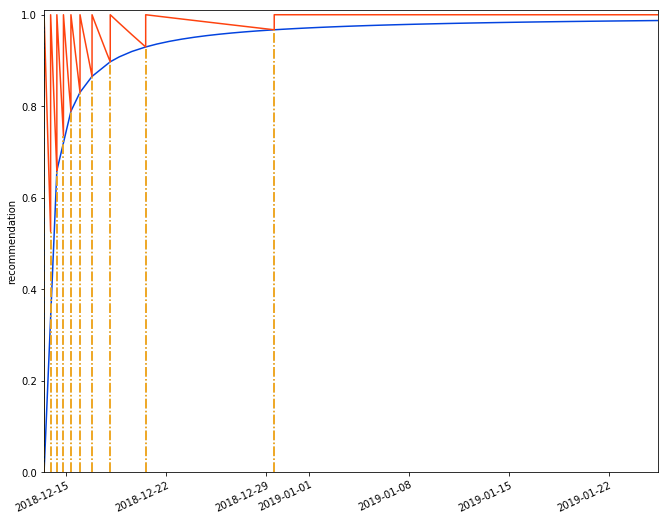

In [2]:
hdl, _  = hr.plot_graph()

In [3]:
# close the plot when you are done save memory
hdl.close()


The graph's x-axis represents time while the y-axis represents the amount a student can remember about the thing they are trying to learn.  The student has perfectly remembered an idea if its score is one and they have utterly forgotten an idea if its score is zero.

The red stickleback looking graph represents how a students recollection ability will rise and fall as a function of training events and the passage of time from a given training event.  At first, a student forgets something quickly, but as they train on an idea, that idea will fade slower from their memory.  The sudden rise of this red line represents a moment when the student studies.  There is an assumption that they will review an idea long enough that their immediate recollection of that idea will be perfect before they stop thinking about it.

The blue line maps to plasticity, or how fast an idea can be mapped into a mind as a function over time.

The training events occur where the forgetting curves of the stickleback approach the plasticity line.  At each intersection of the forgetting curve and the plasticity curve, orange lines are projected downward to the x-axis to provide the suggested times of study.  Collectively, these times are called the schedule.

If you would like to make the plasticity curve less aggresive, you could set your own plasticity parameters.  Here is the default graph:

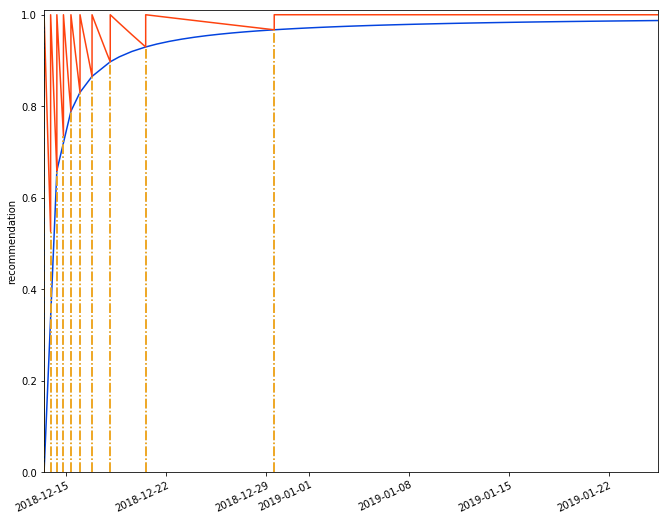

In [4]:
hr = SpaceRepetitionReference(
    range=range_in_days,
    epoch=start_time,
    plasticity_root=1.8, # default
    plasticity_denominator_offset=1.0, # default
)

hdl, _ = hr.plot_graph()

A higher ``plasticity_root`` parameter makes the blue line rise faster.

Let's make a less aggressive plasticity curve, by lowering the default ``plasticity_root`` parameter from it's default value of ``1.8`` to ``0.9``, and we will leave the ``plasticit_offset_denominator`` at its default value of ``1.0``.

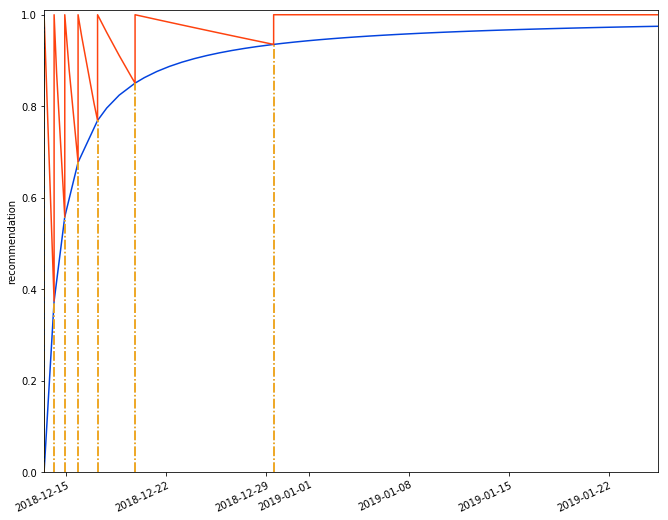

In [5]:
hr = SpaceRepetitionReference(
    range=range_in_days,
    epoch=start_time,
    plasticity_root=0.9,
    plasticity_offset_denominator=1.0,
)

hdl, _ = hr.plot_graph()

In [6]:
hdl.close()

You can change the nature of the forgetting curves, or the red stickle back lines, by adjusting the ``fdecaytau`` and ``fdecay0`` parameters.

The ``fdecay0`` parameter determines the immediate steepness of the forgetting curves.  A higher number will make them more steep, while lower number makes them less steep.

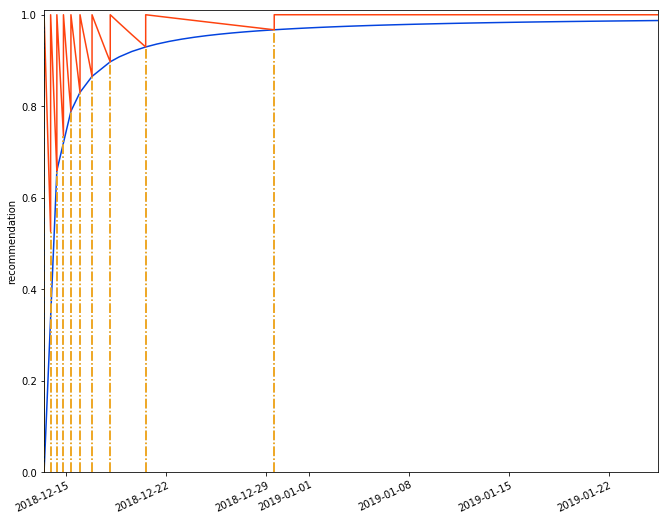

In [7]:
hr = SpaceRepetitionReference(
    range=range_in_days,
    epoch=start_time,
    fdecay0=1.4,  # default
)

hdl, _ = hr.plot_graph()

In [8]:
hdl.close()

If we have observed that the student has a good memory, we might want to reduce ``fdecaytau0`` so that we don't waste their time with unnecessary study sessions.  Here we will change the ``fdecaytau0`` parameter to ``0.4`` from its default of ``1.4``:

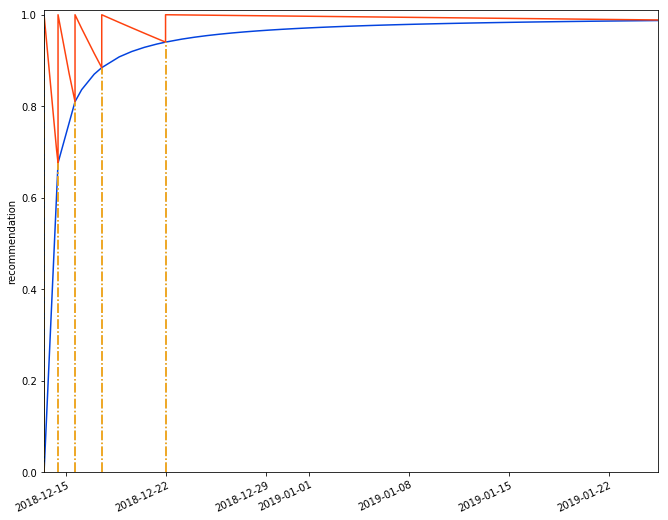

In [9]:
hr = SpaceRepetitionReference(
    range=range_in_days,
    epoch=start_time,
    fdecay0=0.4,
)

hdl, _ = hr.plot_graph()

Think of ``fdecaytau`` as how fast a memory gets better at being retained after each study session.  It's default value is ``1.8``.  If you drop this ``fdecaytau`` parameter, the forgetting curves will flatten out quicker than they do for a higher number.  So, a faster learner would get a lower ``fdecaytau`` parameter:


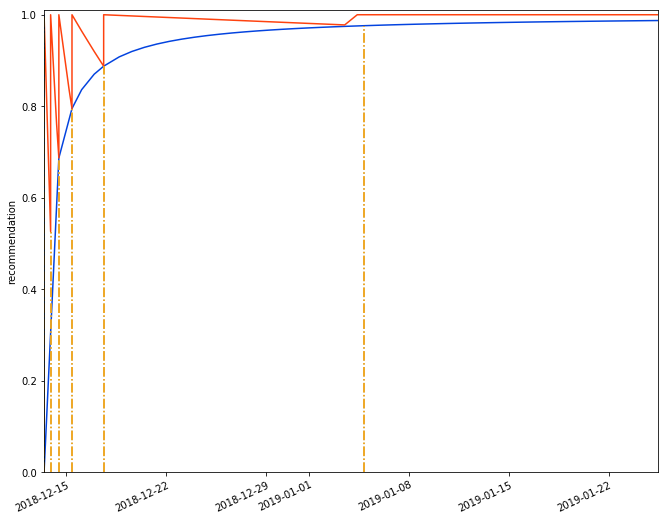

In [10]:
start_time = datetime.now()
range_in_days = 43

hr = SpaceRepetitionReference(
    range=range_in_days,
    epoch=start_time,
    fdecaytau=0.6
)

hdl, _ = hr.plot_graph()

In [11]:
hdl.close()

## Student Feedback
Even if a student dedicates themselves to learning an idea, they still have other priorities to attend too.  It is doubtful that they will be able to train when we want them to.  

Furthermore, the forgetting and plasticity curves used to generate the schedule are unknowable, they are just guesses at what is likely.  To demand someone change their life to meet a plan based upon such fiction is a little perverse.

Let's suppose that our student has been training, even if it isn't precisely when our model requires them to train.   We ask them to rate how well they remember something just before they review it, and then we ask them to report on this result and the time when their review occurred.

Let's put all of this information together and put it into a function called feedback:

In [12]:
def feedback():
  '''
  Here are 10 actual training moments with corresponding results.
  '''
  offset_in_days_from_introduction_to_idea = [
          0,
          0.80640320160080037,
          1.7523761880940469,
          3.0240120060030016,
          4.8074037018509257,
          7.3351675837918959,
          10.932966483241621,
          16.004002001000501,
          23.029014507253628,
          29.029014507253628
        ]
  # how well they could remember the thing prior to training on it
  # so as to get perfect recollection.
  results = [
          0.40,
          0.44646101201172317,
          0.64510969552772512-0.1,
          0.76106659335521121-0.2,
          0.83741905134093808-0.3,
          0.89000147547559727,
          1.00000000000000000,
          0.99994393927347419,
          0.99929261332375605,
          1.00
          ]
  return [offset_in_days_from_introduction_to_idea, results]

feedback()


[[0,
  0.8064032016008004,
  1.752376188094047,
  3.0240120060030016,
  4.807403701850926,
  7.335167583791896,
  10.932966483241621,
  16.0040020010005,
  23.029014507253628,
  29.029014507253628],
 [0.4,
  0.44646101201172317,
  0.5451096955277251,
  0.5610665933552113,
  0.537419051340938,
  0.8900014754755973,
  1.0,
  0.9999439392734741,
  0.9992926133237561,
  1.0]]

We see that the student did well: on the 10th day after which they were introduced to an idea, they could remember it perfectly even though they hadn't looked at it for about three days.

## Spaced adapts to the student using a control system

The spaced library wants to be adaptive to what happens in a student's life.  If a student goes on vacation and ignores their studies for a while, then a new schedule should be provided upon their return which suggests that they look at a thing more often than they would have had they not ignored it while on their break.

To do this, spaced uses a control system.  A control system needs a reference.  Think of this reference as its goal: what does it want to happen and when.  The graph that we have been describing up until this point will serve as our goal.  A control system also requires information about what the thing it's trying to control is doing. This is called feedback.  

The difference between its goal and this feedback represents the system's error, or how bad it is doing in trying to achieve its goal.  This error changes over time and it is used by the control system to determine how much will to exert upon the thing it is trying to control.  It is trying to reduce its error to zero.

So, if a student where to go on vacation and forget about their studies for a while, the control system would experience a significant error when the student came back and activated it again.  This would cause the control system to exert its will by suggesting a very aggressive schedule for the student.  If the student studied intently and got results (maybe because they are feeling good and relaxed from their vacation), the control system would exert less control and expand out the schedule for future training suggestions.

An error can be made in the other direction too.  If a student studies too much and improves faster than expected, the spaced algorithm will relax their learning schedule.

Let's take a look at how spaced does this over time.

Consider the first couple of training examples:

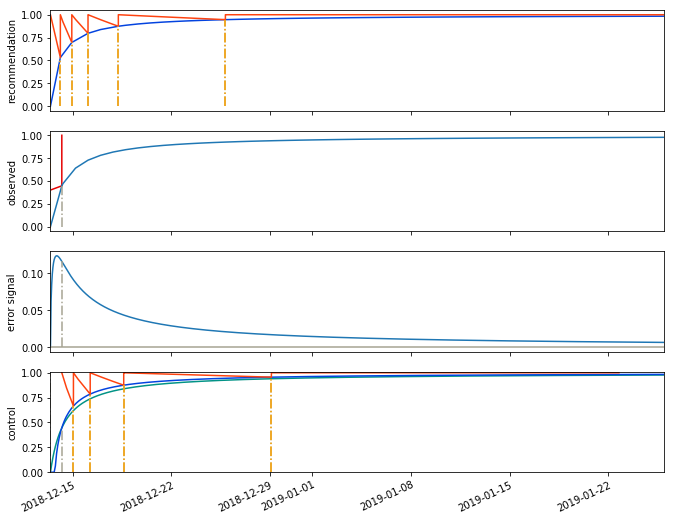

In [13]:
from repetition import SpaceRepetitionReference
from repetition import SpaceRepetitionFeedback
from repetition import SpaceRepetitionController
import numpy as np
from datetime import datetime
from datetime import timedelta

start_time    = datetime.now()
x, y          = feedback()
range_in_days = x[-1] * 1.5

# setting up our reference (goals)
hr = SpaceRepetitionReference(plasticity_root=1.4, # for slower learning, pick lower numbers
                              fdecaytau=1.00,      # ability to improve after a lesson, lower is better
                              fdecay0=0.9,         # seen it before? then pick lower numbers
                              epoch=start_time,
                              range=range_in_days,
)

# what actually happened (feedback), range and epoch determined from hr
hf = SpaceRepetitionFeedback(x[0:2], y, range=range_in_days)

# giving our control system the reference and the feedback
hctrl = SpaceRepetitionController(reference=hr, feedback=hf)
hdl, _ = hctrl.plot_graphs()



In [14]:
# close the graph to save memory
hdl.close()

The recommended graph is the reference feed (goal) to the control system; the observed graph is the part of our feedback that we feed to the control system.  The difference between what we wanted and what we got is plotted on the error signal graph, and this information is used to generate the last graph, the control graph, which will suggest new times to study.

To see these times, you can ask it for its schedule:

In [15]:
hctrl.schedule()

[datetime.datetime(2018, 12, 16, 6, 1, 57, 234444),
 datetime.datetime(2018, 12, 18, 15, 5, 58, 771976),
 datetime.datetime(2018, 12, 29, 2, 33, 5, 165723)]

Let's look at how ``spaced`` responds to the next set of training events.  We see that from the observed graph that the student isn't doing as well as we hoped.  In response spaced is suggesting an aggressive schedule:

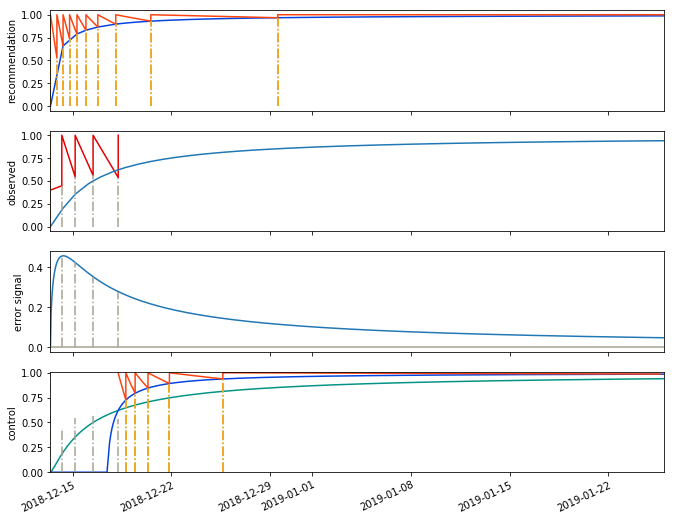

In [16]:
start_time    = datetime.now()
x, y          = feedback()
range_in_days = x[-1] * 1.5

# setting up our reference (goals)
hr = SpaceRepetitionReference(epoch=start_time,
                              range=range_in_days)

# what actually happened (feedback), range and epoch determined from hr
hf = SpaceRepetitionFeedback(x[0:5], y, range=range_in_days)

# giving our control system the reference and the feedback
hctrl = SpaceRepetitionController(reference=hr, feedback=hf)
# %timeit SpaceRepetitionController(reference=hr, feedback=hf)
hdl, data_dict = hctrl.plot_graphs()

In [17]:
# close the graph to save memory
hdl.close()

# What is being controlled anyway?

For a control system to work, we need to know a few things.  We need to know what we want, this is called the reference, and we need to know what actually happened, this is called feedback.

As previously mentioned, the reference is the dark blue line representing the plasticity curve in the first graph.

With the spaced algorithm, the feedback data is used to build a second plasticity curve, which can be seen in the second and forth boxes as a light blue line.  This second plasticity curve is the observed plasticity curve.  It is a model of how the student is actually learning the idea being tracked.  While ``spaced`` is making this curve, it puts extra emphasis on the most recent data provided by the student.  This is because a student's recent understanding should outweigh their previous ignorance.   The observed plasticity curve is constructed using the ``curve_fit`` method of the ``scipy.optimize`` library.  The ``curve_fit`` method finds values of ``plasticity_root`` and ``plasticity_denominator_offset`` that minimize the difference between the observed plasticity curve, and the feedback provided by the student.

After a training session, the ``spaced`` algorithm shifts the blue reference line such that it intersects with the light blue observed plasticity curve, then re-draws the forgetting curves, which causes projections onto the timeline which represent the updated schedule (This is a kind of feedforward loop).  Well, this is very close to what happens, we are missing one little step.

When we begin to track a student's learning, we make assumptions about how fast they forget.  But we don't actually know how fast they will forget something, so the ``spaced`` algorithm tries to match the forgetting curves used by the control graph, to what they look like in the student's observed graph.

Specifically, the ``fdecaytau`` and the ``fdecay0`` are adjusted, so that the forgetting curves in the control graph fall at similar rates as they do in the observed graph.    It will be very difficult to tune these control parameters, since we have no way of actually modelling the system. (the interaction between the student's mind, their environment, the training material, the context in which they train...)  For now, we will be happy with making mistakes in the right direction.

To change the control system parameters:

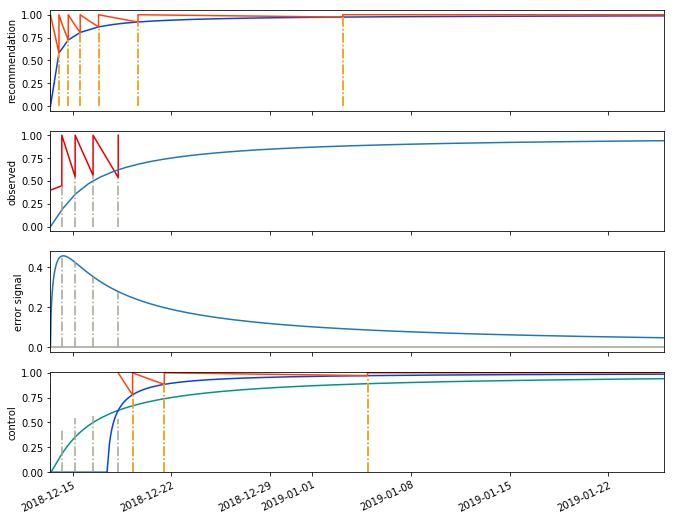

In [18]:
from repetition import SpaceRepetitionReference
from repetition import SpaceRepetitionFeedback
from repetition import SpaceRepetitionController
import numpy as np
from datetime import datetime
from datetime import timedelta

start_time    = datetime.now()
x, y          = feedback()
range_in_days = x[-1] * 1.5

# setting up our reference (goals)
hr = SpaceRepetitionReference(plasticity=1.4,    # for slower learning, pick lower numbers
                              fdecaytau=1.00,    # ability to improve after a lesson, lower is better
                              fdecay0=0.9,       # seen it before? then pick lower numbers
                              epoch=start_time,
                              range=range_in_days,
)

# what actually happened (feedback), range and epoch determined from hr
hf = SpaceRepetitionFeedback(x[0:5], y, range=range_in_days)

# giving our control system the reference and the feedback
hctrl = SpaceRepetitionController(
    reference=hr,
    feedback=hf,
    # control parameters begin
    fdecaytau_kp=1.0,  # kp for fdecay control (PID)
    fdecaytau_ki=0.1,  # ki " "
    fdecaytau_kd=0.04, # kd " "
    fdecay0_kp=1.0,    # kp for fdecaytau_kp (PID)
    fdecay0_ki=0.1,    # ki " "
    fdecay0_kd=0.03,   # kd " "
    # control parameters end
)
hdl, _ = hctrl.plot_graphs()

In [ ]:
hdl.close()

This PID re-shaping of the controller's plasticity curve is very subdle, and it isn't that important.  Think of it as the model trying to fix it's initial bad assumptions about how a student forgets.

What is important is to understand that the dark blue line shifts to the left in the fourth box when a student is doing better than we expected and it shifts to the right when they are doing worse.

## Queries about a future recollection
We have some nice graphs and we have a schedule, but let's say we want to ask spaced to predict something. For example, let's say we want to predict what the recollection numbers will be for the second forgetting curve of its control output.  In addition to this, we would like to understand the context about our query's results, by plotting them onto the control graph.  To do this with ``spaced``, we could write this code:  

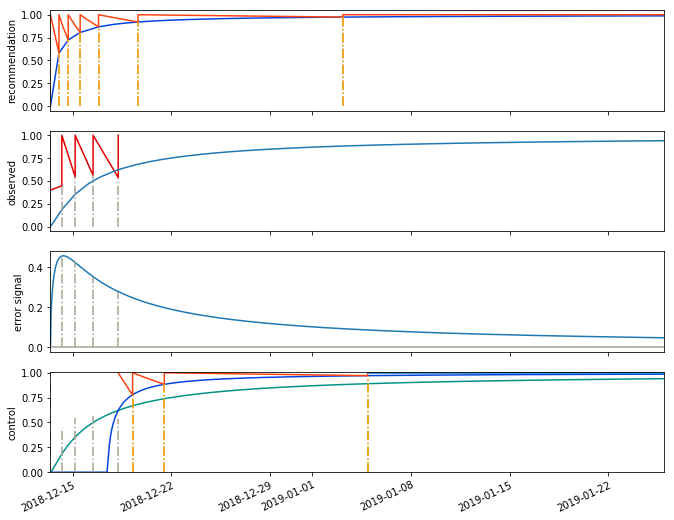

In [ ]:
# plot the graph and get it's handle
graph_handle, data_dict = hctrl.plot_graphs()

curve = 2
# get a set of datetimes
useful_range_of_datetimes = hctrl.range_for(curve=curve, range=10, day_step_size=0.5)

# make a results query using these datetime
results = [hctrl.recollect_scalar(moment, curve=curve) for moment in useful_range_of_datetimes]

# control plot is the last box
control_plot = graph_handle.axarr[-1]
_ = control_plot.plot(useful_range_of_datetimes, results, color='xkcd:azure')


In [ ]:
# close the graph to save memory
graph_handle.close()

Realistically speaking, we don't care about any forgetting curve that isn't the first curve.  So, let's plot the first curve's data onto the control graph:

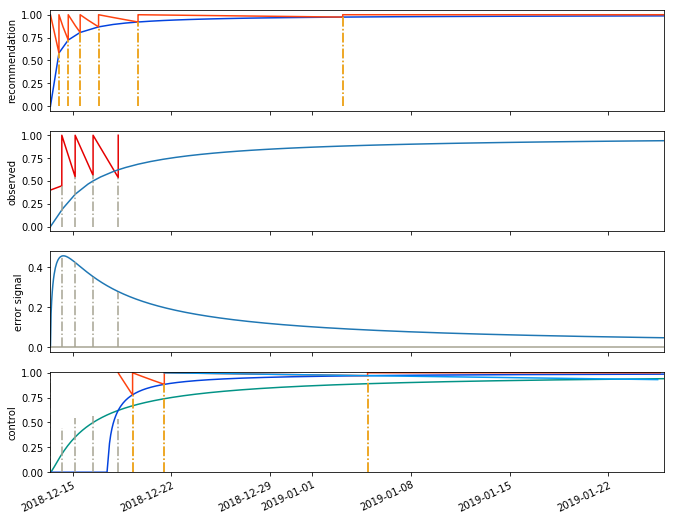

In [ ]:
# plot the graph and get it's handle
graph_handle, data_dict = hctrl.plot_graphs()

curve = 1
# get a set of datetimes
useful_range_of_datetimes = hctrl.range_for(curve=curve, range=10, day_step_size=0.5)
# make a results query using these datetime
results = [hctrl.recollect_scalar(moment, curve=curve) for moment in useful_range_of_datetimes]

# control plot
control_plot = graph_handle.axarr[-1]
_ = control_plot.plot(useful_range_of_datetimes, results, color='xkcd:azure')


Once we trust that the algorithm is working, we probably won't graph it's information anymore, we will ask it for its suggestion about the next lesson's ``datetime`` schedule:


In [ ]:
hctrl.next_lesson()

datetime.datetime(2018, 12, 21, 12, 11, 54, 76383)

If we use spaced within another library, we may want to ask it what the learning score will be for this particular thing that is being studied at a specific ``datetime``:


In [ ]:
# find some future query time that makes sense for our example
query_time = hctrl.datetime_for(curve=1) + timedelta(days=1.5)

# the recollection_scalar's api defaults to the first forgetting curve
result = hctrl.recollect_scalar(query_time)
print(result)

0.9969513290359996


# Simplified API
Rather than having to build multiple objects then feed them into one another, we will use the LearningTracker class which does this work for us:

In [ ]:
from datetime import datetime
from repetition import LearningTracker


ltr = LearningTracker(
  epoch = datetime.now(),
  # plasticity_root=1.8,
  # fdecaytau=1.2,
  # fdecay0=1.4,
  # fdecaytau_kp=1.0,
  # fdecaytau_ki=0.1,
  # fdecaytau_kd=0.4,
  # fdecay0_kp=1.0,
  # fdecay0_ki=0.1,
  # fdecay0_kd=0.3,
)



Even without feedback, we can plot our graphs and view our schedule:

In [ ]:
from repetition import pp
hdl, _ = ltr.plot_graphs()
pp(ltr.schedule())
pp(ltr.schedule_as_offset_in_days_from_epoch())

[ datetime.datetime(2018, 12, 14, 7, 50, 17, 63297),
  datetime.datetime(2018, 12, 14, 18, 55, 28, 272838),
  datetime.datetime(2018, 12, 15, 7, 30, 15, 549010),
  datetime.datetime(2018, 12, 15, 22, 46, 49, 378051),
  datetime.datetime(2018, 12, 16, 19, 0, 12, 759757),
  datetime.datetime(2018, 12, 18, 1, 36, 28, 482484),
  datetime.datetime(2018, 12, 20, 13, 12, 23, 155842),
  datetime.datetime(2018, 12, 29, 13, 18, 16, 736275)]
[ 0.4589442709995035,
  0.8952268306891566,
  1.3571621263040674,
  1.881320415336438,
  2.517823066268917,
  3.3604547989757783,
  4.635636774985627,
  7.118908457377074,
  16.123000823500735]


In [ ]:
hdl.close()

When spaced is used out in the world, the feedback will be provided as it occurs, not after all of the training sessions are over.  Here is how we can simulate the feeding of live data (who's ``when`` variable is an offset from the learning epoc in days) into the learning tracker, using our feedback function:

In [ ]:
# get some results and when they occurs from the feedback function (from now till 30 days from now)
moments, results = feedback()

# build a new learning tracker setting it's learning epoch to now
ltr = LearningTracker(epoch = datetime.now())
    
# feed in the first four samples from our feedback set, then stop
for index, (moment, result) in enumerate(zip(moments, results)):
    
  # HERE we see how to feed the learning-tracker its data as we get this data
  ltr.learned(result=result, when=moment)
    
  # break out of our loop on the fourth item
  if index == 3:
    break;

# now print how the system is responding to the trainin up to the fourth sample
hdl, _ = ltr.plot_graphs()

In [ ]:
hdl.close()

You can also enter your feedback as a datetime:

In [ ]:
# get some results and when they occurs from the feedback function (from now till 30 days from now)
moments, results = feedback()

# build a new learning tracker setting it's learning epoch to now
ltr = LearningTracker(epoch = datetime.now())
    
# feed in the first four samples from our feedback set, then stop
for index, (moment, result) in enumerate(zip(moments, results)):
  
  moment_as_datetime = ltr.epoch + timedelta(days=moment)
    
  # HERE we see how to feed the learning-tracker its data as we get this data
  ltr.learned(result=result, when=moment_as_datetime)
    
  # break out of our loop on the fourth item
  if index == 3:
    break;

# now print how the system is responding to the trainin up to the fourth sample
hdl, _ = ltr.plot_graphs()

In [ ]:
hdl.close()

## Getting a gut feel about what is going on
There are a lot of things that will affect a student's recollection of an idea.  Did they study?  Is our lesson approach sticky (plasticity)?  Are they distracted? How are the forgetting curves changing over time?  Given that there is a control system at play, is it appropriately tuned?  We would like to see a report card on this one thing; this report card will describe the relationship between our training material and the student's work and when they worked.

To provide such information we can make a movie of the space algorithm's reaction to what happened in the world.  If you understand what the graphs mean, then you will be able to watch the video and infer if the model is wrong, if the student is studying and possibly other things too.



In [ ]:
%%HTML
<video height="600" controls>
  <source src="results/example.mp4" type="video/mp4">
</video>


As you play the video, you see a story unfold about the relationship between our model and the student's reaction to it.  In the first five days of their training, we see that they made more mistakes than we would have liked, then, around the seventh day, something clicks for them, and they do better than what was predicted by the original model.

We can see that the control system tried to get them to do much more training when they were doing poorly, and less training when they started to understand the material.  When the dark blue reference curve in the control box moved to the left, the student was doing better than expected, and when it shifted to the right, the student was doing worse than expected.

We also see that our initial forgetting curves were too pessimistic, and as a result our initial schedule was too aggressive. But after a few training events, the ``spaced`` algorithm began to match the forgetting parameters to how the student actually forgot things.

The light blue line is an imagined plasticity curve that describes the student's performed-plasticity.  It will be a function of when they study, how distracted they were at the time and other environmental factors mixed with their rate of learning.

The video plays a training event every second, which means that we are accelerating time since the training events become more and more spaced out the later they occur.

To generate your own animation:

In [ ]:
from datetime import datetime
from repetition import LearningTracker

student_name = "Marnie MacMillan"
moments, results = feedback()

# Create a learning tracker for Marnie
ltr = LearningTracker(
  epoch = datetime.now(),
  # give her some custom parameters 
  plasticity=1.4,
  fdecaytau=1.87,
  fdecay0=0.9
)
    
# Simulate Marnie's training over the next thirst days
for index, (moment, result) in enumerate(zip(moments, results)):
  ltr.learned(result=result, when=moment)
   
# Now animate her results
ltr.animate(
  student="Marnie MacMillan",
  name_of_mp4="results/report_card.mp4",
  time_per_event_in_seconds=2.2,
)



# Reflection and learning about the Student
The learning tracker contains a lot of information.

It tunes it's forgetting-parameters so as to mimic how a student forgets, and it builds an observed plasticity curve based on how the student learns.  So we could use these discovered parameters to build a better version of the learning-tracker 
the next time we make one for that student.  It follows then, that we would like to be able to query the learning tracker in two ways, what were the tuning parameters at the training epoch, and what are they now.

Let's consider how we would start making schedules, we would guess at our parameters then let the student train on an idea:

In [ ]:
from repetition import LearningTracker

# create a learning tracker
lt = LearningTracker(
    epoch=datetime.now(),
    plasticity_root=1.8,
    plasticity_denominator_offset=1.0
)

timed_learning_tracker = LearningTracker(epoch=datetime.now(), plasticity_root=1.8, plasticity_denominator_offset=1.0)

# simulate training over the feedback duration
moments, results = feedback()
for moment, result in zip(moments, results):
    lt.learned(result=result, when=moment)
    
# draw a picture based on our guesses about the student's plasticity curve and forgetting curves
hdl, _ = lt.plot_graphs()

# what did spaced learn about the student?
# it was paying attention to the plasticity and forgetting curves... so we can reflect upon its discoveries
print(lt.discovered_plasticity_denominator_offset())

In [ ]:
hdl.close()

The learning tracker built an observed plasticity curve (the light blue line in the fourth box) based on the feedback the student provided while training on their idea.  We can ask ``spaced`` to reflect upon these discovered plasticity-curve parameters like this:

In [ ]:
print("discovered plasticity_root: {}".format(lt.discovered_plasticity_root()))
print("discovered plasticity_demoninator_offset: {}".format(lt.discovered_plasticity_denominator_offset()))

Likewise, ``spaced`` learned about the forgetting curves by watching the student's feedback.  We can ask ``spaced`` to reflect upon these discovered forgetting-curve parameters like this:

In [ ]:
print("discovered fdecay0: {}".format(lt.discovered_fdecay0()))
print("discovered fdecaytau: {}".format(lt.discovered_fdecaytau()))

These discovered parameters can be used to make a better first guess about how our student learns and how they forget, while working in their environment.  So let's build our reference curve based on these discoveries and re-apply the feedback and see how the ``spaced`` algorithm responds:

In [ ]:
# for our next learning tracker, we use the insights gleaned from our first one
lt_next = LearningTracker(
  epoch = datetime.now(),
  plasticity_root=lt.discovered_plasticity_root(),
  plasticity_denominator_offset=lt.discovered_plasticity_denominator_offset(),
  fdecay0=lt.discovered_fdecay0(),
  fdecaytau=lt.discovered_fdecaytau()
)

# simulate the learning of this new idea using the old feedback data, 
# stop after the fourth training event and print the results
moments, results = feedback()
for index, (moment, result) in enumerate(zip(moments, results)):
    lt_next.learned(result=result, when=moment)
    if index == 3:
        break
        
hdl, _ = lt_next.plot_graphs()

In [ ]:
hdl.close()

Knowing that our model is better now, we can see from the control plot that our student is doing worse than we would have liked on their fourth training attempt.  We see this from the error plot, which is positive and from the dark blue line in the control plot being shifted to the right.  

The good news about this plot is that we can believe it more than we could have had we just made guesses about the student's plasticity curve, and pessimistic estimates that they forget very very quickly.

The model helps them learn, and their feedback can be used to teach the model.  So in a way, the ``spaced`` algorithm can be used to build a computer-human relationship.

The learning tracker consumes the results and times of those results as the student progresses.  To reflect upon these results, you can use the ``feedback`` api:


In [ ]:
from repetition import TimeFormat

# for our next learning tracker, we use the insights gleaned from our first one
lt = LearningTracker(epoch = datetime.now())

# simulate the learning of this new idea using the old feedback data, 
# stop after the fourth training event and print the results
moments, results = feedback()
for index, (moment, result) in enumerate(zip(moments, results)):
    lt.learned(result=result, when=moment)
    
# reflect upon the feedback that was given to the learning tracker
print("\nfeedback as time from epoch in days with result")
pp(lt.feedback())

print("\nfeedback as time from epoch in days with result")
pp(lt.feedback(time_format=TimeFormat.OFFSET))

print("\nfeedback as datatimes with result")
pp(lt.feedback(time_format=TimeFormat.DATE_TIME))
        


The graphs and the animation discussed above are a type of object reflection.  But if you are building a system, you won't want to look at every single graph, or create an animation for every learning tracker; there could be hundreds of thousands of them.  You will only want this capability if you are curious about a particular thing.  So the learning tracker shouldn't always generate graphs and animations, instead it should keep a fairly light memory-foot-print during its normal operation.

# Serializing (Pickling) a Learning Tracker
A specific learning tracker will be used very infrequently over time.  It contains a lot of data, but this data can quickly be re-computed if we know what the feedback is and what the tuning parameter were at the training epoch, and when the training epoch was.  For this reason, ``spaced`` pickles a learning tracker using the least amount of disk space.